# POTHOLE ANALYTICS

#### Nate Gentry, Ronak Rana, Mazdul Chaudhry, Arowosegbe Ayodeji, Bazil Chaudhry

# EXECUTIVE SUMMARY

We began the project with an agenda to analyze the 311 services data in terms of type of request, historical trends, seasonal fluctuations, and neighborhoods. The goal was to check the number of days it takes to fix the requests and find if any anomaly is due to skewed service quality of 311 service departments (PWD, Fire, and Police).

When we started working of the data, we quickly realized that the data needs a lot of cleaning and refinement and that would take the bulk of our time and effort. In order to respect that, we pivoted our strategy to focus just on a single request type. 
We chose Potholes as it was one of the most frequently requested services on 311 and potholes occurences were fairly uniform across the Boston map. When we further researched potholes we found that the cost of damage to cars caused by potholes was 3 billion dollars to US drivers annually; a cost of around 300 dollars per year to the average American motorist. Furthermore, potholes cost the average Boston motorist an additional 468 dollars in extra vehicle operating costs, including accelerated vehicle depreciation, repair costs, increased fuel consumption and tire wear. In addition to that around 81% of Urban Boston roads had been rated mediocre, while 7% had been considered poor. We also found that the Boston City public works department had benchmarks for performance for the city that we could further look into as part of our analysis. The benchmark they had set was that they would repair potholes within 2 days time and that they meet this expectation 80% of the time. 

This wealth of information persuaded us to look into potholes as a service whose improvement could have a financial impact on not only the city but also the wallets of averge Bostonians. While looking in to the pothole service we explored a number of different question leading to our final hypotheis test which was – “The Boston Public Works Department is providing the same quality of service to all the neighborhoods”. 

To measure the service quality, the metric we focused on was the number of days it takes to fill the pothole in different neighborhoods. To measure the fairness of the service we got the demographic data from 2014 American Communities Survey conducted by US census department and ran a regression to see if there is any association between the two. To show all the data cleaning, analysis and presentation (tableau) work we did, we will walk through all the steps chronologically in this notebook. 

Our conculsion is that while there is a correlation between a Boston zip code's percentage of on-time cases closed, the number of cases that have occurred within that zip code, and certain demographic factors; there is nothing to suggest causation. We recommend potential further analysis which includes looking at complaints via service method(app,phone call), traffic data, construction data and even actual repair times to better determine any significant factor that could lead to causation.

# PART 1: DATA REFINEMENT USING OPEN REFINE

We downlaoded the 311 service request data from the Boston city government website.The data was then loaded into open refine. The open date and closed date columns had date and timestamp in a single field. The following procedure was used to separate the date and time into separate columns for date and time for each column (Open Date and Closed Date).

Individual steps: In the option menu against the column name, select ‘Edit Column’ —> ‘Split into several columns’. Blank space was used as a separation condition. The result we got was two separate columns for each column, one containing only date and the other one only time.

# PART 2: DATA WRANGLING

### Loading the data into python

In [1]:
# Our standard set of imports for pandas, numpy and matplotlib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from math import sqrt

# some imports to handle HTML requests and parsing the results
from StringIO import StringIO
import requests

mpl.style.use('fivethirtyeight')

potholes = pd.read_csv('https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/311potholesonly-2.csv')


C:\Users\ngentry13\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We loaded the data and created a data frame with just the requests for potholes. 

In looking at the data we found that some cases were still open when we pulled the data. For such rows the closed case date cell was empty, we therefore filled those cells with today's date in order to determine the number of days the case had been open. Next we converted the string values in the opening and closing date into datetime so that we could further subtract them and come up with a measure known as Days Open. We then used the Days Open measure to create a new column called Target Hit which assigns a 1 if the case was closed in 2 days or less and a 0 if the case was open for 3 or more days.

In [2]:
potholes['CLOSED_DT_1']= potholes['CLOSED_DT_1'].fillna('4/26/2016')
potholes['OPEN_DT_1'] = pd.to_datetime(potholes['OPEN_DT_1'])
potholes['CLOSED_DT_1'] = pd.to_datetime(potholes['CLOSED_DT_1'])
potholes['DAYS_OPEN'] = potholes['CLOSED_DT_1'] - potholes['OPEN_DT_1']
potholes.rename(columns={'neighborhood':'Old_Hood'}, inplace=True)
potholes['Target_Hit']= np.where(potholes['DAYS_OPEN']<'3 days',1,0)

Another issue we faced in the data was that any request that was made for an intersection as opposed to a specific address was assigned a neighborhood but not a zip code, over 12,000 cases had this issue. Since the demographic data we had available from the Census Bureau was specific to zip codes and not neighborhoods, we needed to find a way to assign these cases their appropriate zips to make almost half of our data useable. To do this we took a csv file from the city which had all of the zip codes within each neighborhood and used it to standardize our existing zip codes by neighborhood and assign zip codes to cases that were missing them by using the neighborhood as an index.

In [3]:
Zipcodes= pd.read_csv('https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/Zips_by_Neighborhood.csv')
potholesv2= pd.merge(potholes, Zipcodes, how='left', on='LOCATION_ZIPCODE')
potholesv2.rename(columns={'Clean Neighborhoods':'Clean_Neighborhood'}, inplace=True)
Hoods = pd.read_csv('https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/Neighborhoods_by_Zip.csv')
potholetest= pd.merge(potholesv2, Hoods, how = 'left', on = 'Old_Hood')
potholetest['LOCATION_ZIPCODE_x'].fillna(potholetest['LOCATION_ZIPCODE_y'], inplace=True)
potholetest['Clean_Neighborhood'].fillna(potholetest['Clean Neighborhoods'], inplace=True)
potholetest = potholetest.drop(['LOCATION_ZIPCODE_y','Clean Neighborhoods'],axis=1)

With the zip codes for our cases now assigned we were able to merge in the demographic data from the US Census' 2014 American Communities Survey. For ease of importing we cleaned the data and converted to a csv file in Excel. The resulting data set gave us for each zip code in Boston, the total number of households, the median average income, and the percentage of white residents. Using a merge we added these data points to each case using the zip code as the key. At this point our data was ready for further exploratory analysis.

In [4]:
Demodata = pd.read_csv("https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/Mass_Demo_Data.csv")
potholetest2 = pd.merge(potholetest, Demodata, how='left', on='LOCATION_ZIPCODE_x')
potholetest2['Total_Cases']= potholetest2['Target_Hit']

# PART 3: Exploratory Analysis

We started out the explorative analysis by trying to find a trend in the service request since the city started collecting the data in 2011. To do this, we created an extra column called 'Year' as shown below. This is used to group the service request and the resultant table and chart shown below

In [5]:
potholetest2['Year'] = pd.DatetimeIndex(potholetest2['OPEN_DT_1']).year
trend_Request = potholetest2.groupby('Year')['CASE_ENQUIRY_ID'].count()
trend_Request

Year
2011    1636
2012    5046
2013    5961
2014    9091
2015    8470
2016    3049
Name: CASE_ENQUIRY_ID, dtype: int64

To take the by year cases analysis a step further we put the data into Tableau and mapped each of the cases and then created a different view for each year. These maps are shown below.

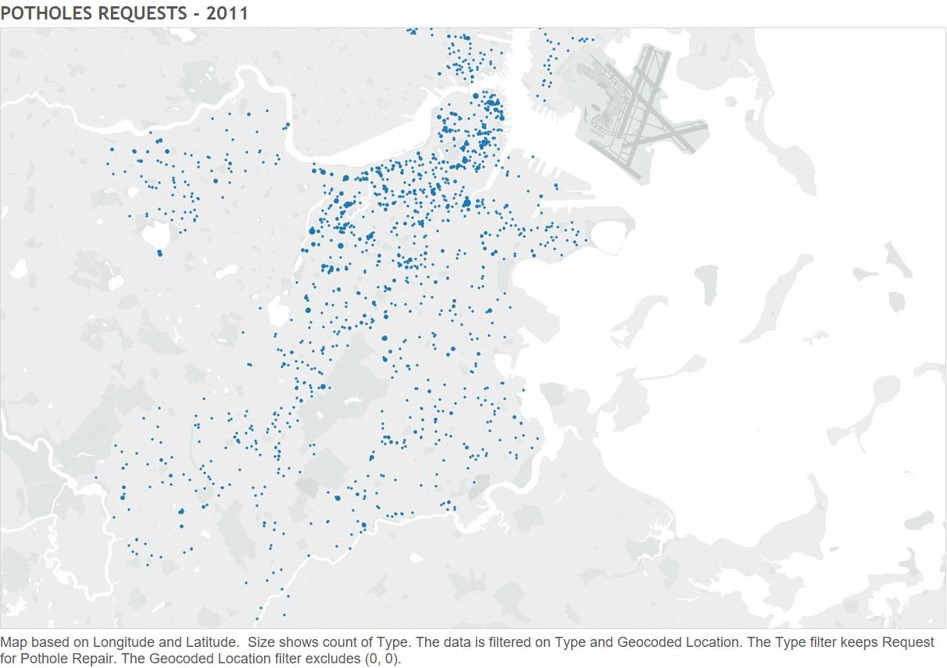

In [6]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/2011.jpg")

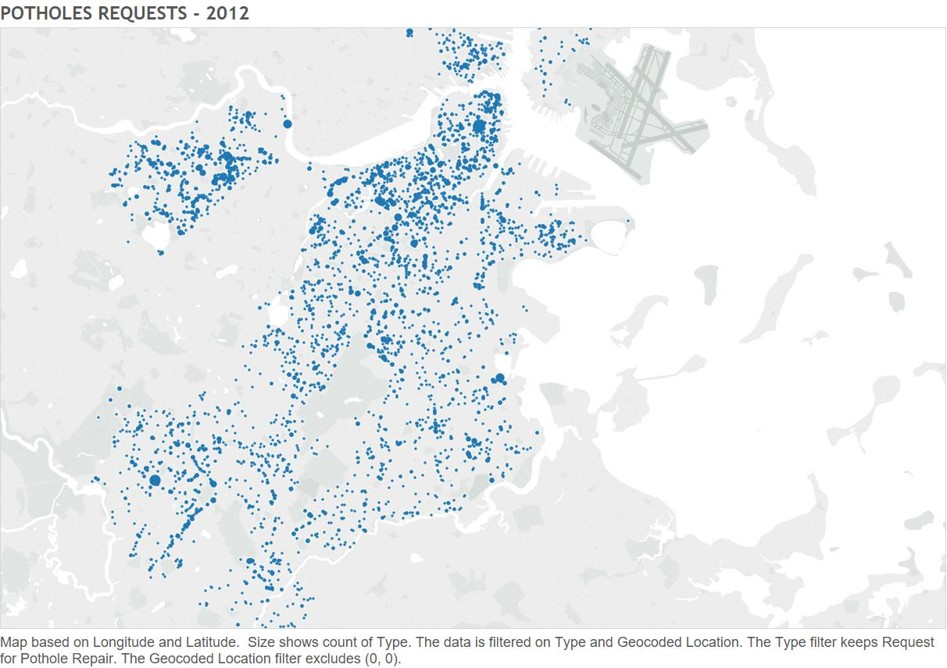

In [7]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/2012.jpg")

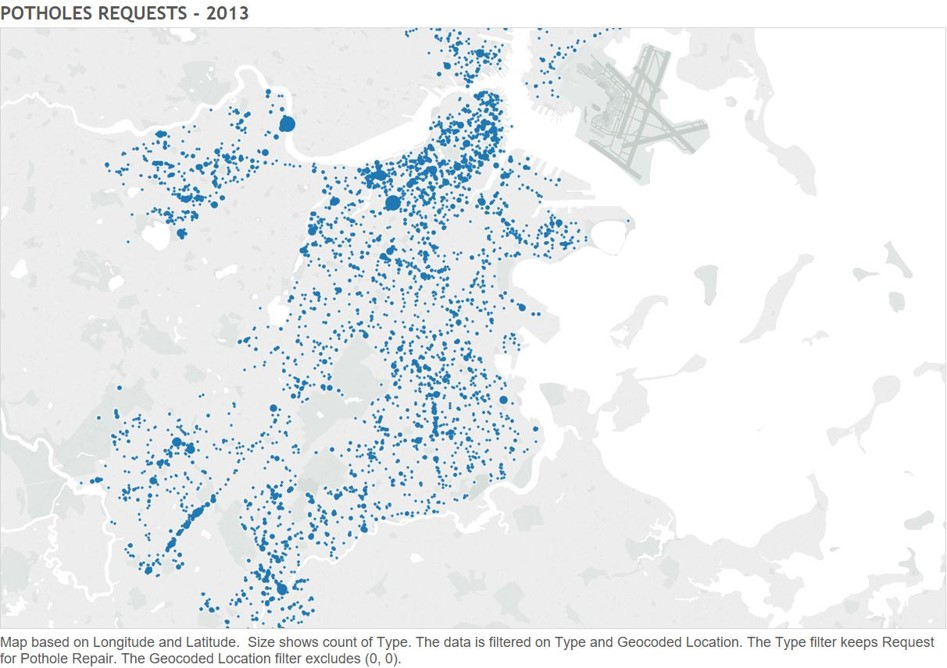

In [8]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/2013.jpg")

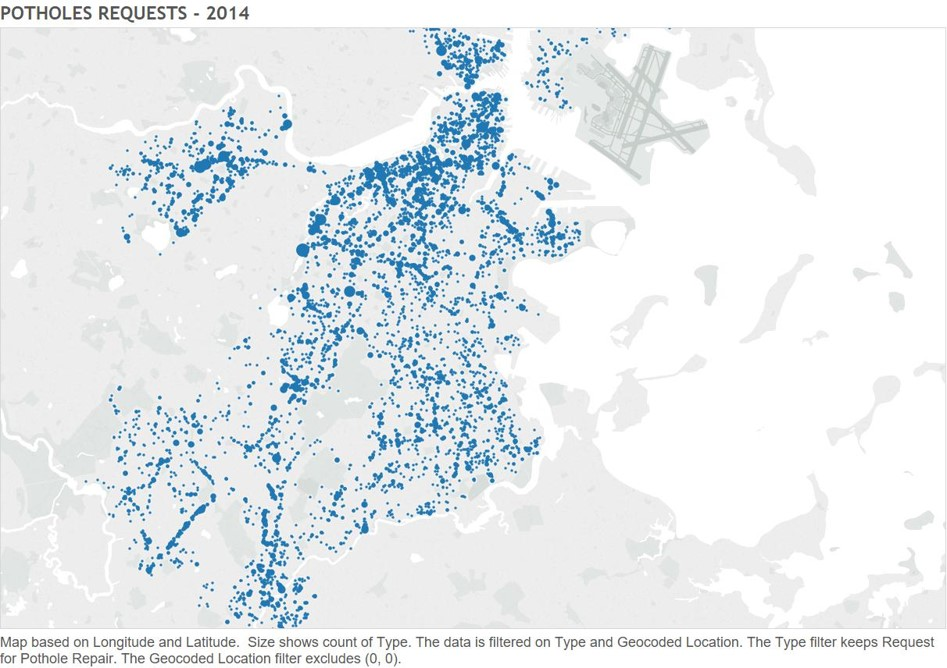

In [9]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/2014.jpg")

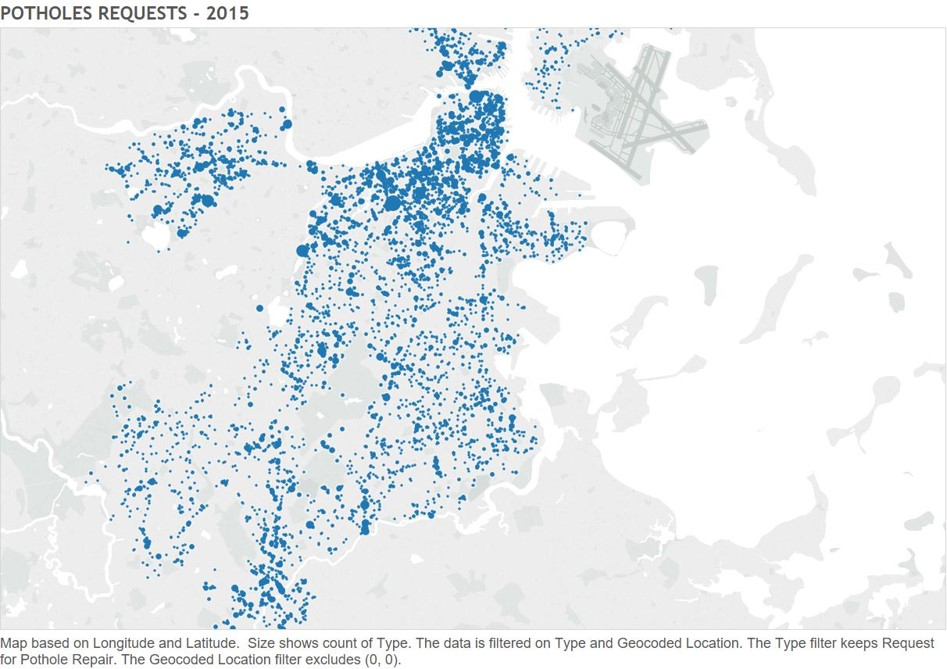

In [10]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/2015.jpg")

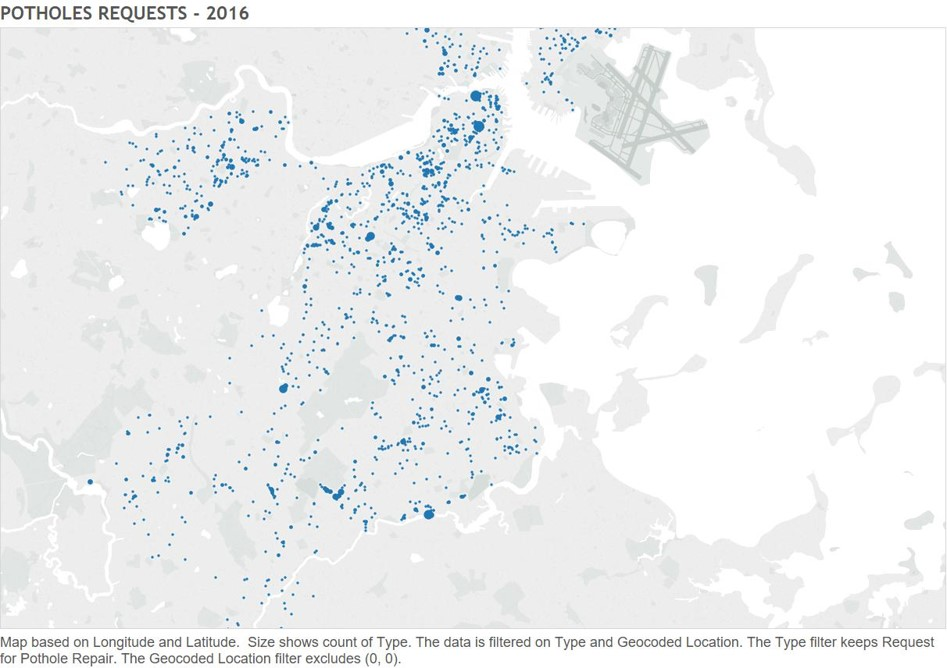

In [11]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/2016.jpg")

Next we looked at target hit rate percentages for the whole city by year to see if there were any notable trends.

In [12]:
trend_TargetHit = potholetest2.groupby('Year')['Target_Hit'].mean()
trend_TargetHit

Year
2011    0.783007
2012    0.889616
2013    0.826539
2014    0.797492
2015    0.667296
2016    0.804198
Name: Target_Hit, dtype: float64

From the table above, we realised a marked reduction in target hit in 2015. We therefore decided to explore the 2015 data to really find out what the problem was

In [13]:
twenty_fif = potholetest2[(potholetest2['Year'] == 2015)]                       
twenty_fif['Month'] = pd.DatetimeIndex(twenty_fif['OPEN_DT_1']).month
trend_TargetHit_mean = twenty_fif.groupby('Month')['Target_Hit'].mean()
trend_TargetHit_mean

C:\Users\ngentry13\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Month
1     0.675824
2     0.349558
3     0.772844
4     0.689799
5     0.722426
6     0.761290
7     0.644809
8     0.643956
9     0.585185
10    0.704319
11    0.658986
12    0.760000
Name: Target_Hit, dtype: float64

Looking into the 2015 data, we noticed a dip in the target hit rate in the second month, February. This dip corresponded with the record snow storm that hit Boston. Ultimately this one month dragged down pot hole repair rates for the whole year.

Lastly we created a heat map using the zip codes and the average target hit percentage in each to see if there was a noticable difference in the metric across the city. That map is shown below.

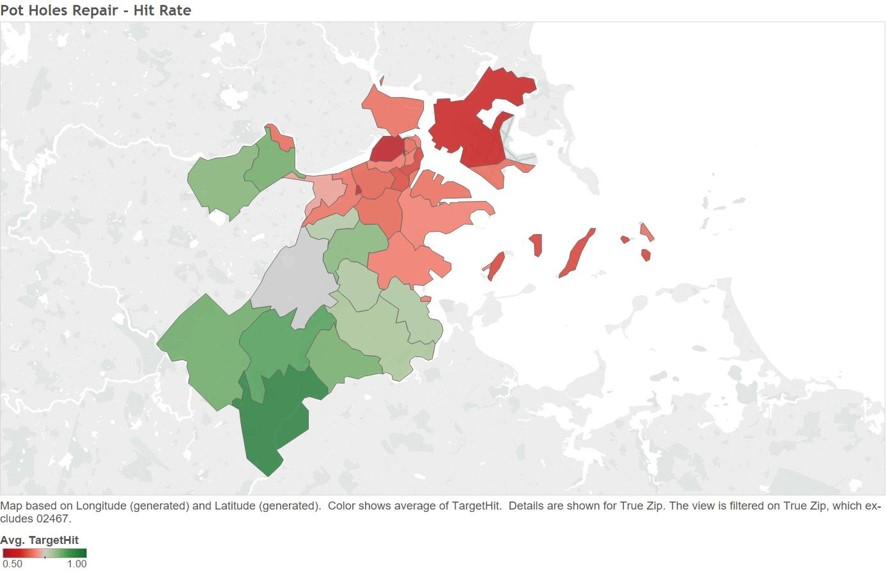

In [14]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/mazdul/Analytics_Enterprise/master/Neighborhood%20Map.jpg")

The darker green areas represent zip codes whose target hit percentage is closest to 100 while the red areas are closer to 50. Clearly there is a discrepency in service between different zip codes. In the next section we will use the demographic data we recieved from the Census Bureau to assess whether or not there is a correlation between the different demographic makeups of each zip code and the percentage of their pothole cases that are closed within the target time set by the city.

# PART 4: Regression Analysis

For the purposes of the regression we wanted to use the aggregate data for each zip code. To do this we created a pivot table that had a column for target hit percentage and all of our zip code demographic columns. We also decided to include the total count of cases for each zip code in the data set to account for any potential correlation between how often the city fixed potholes in the zip code with how fast they were fixed. The below chart is the completed pivot table.

In [15]:
pivot = pd.pivot_table(potholetest2, index=('LOCATION_ZIPCODE_x'), values=['Total_Cases','Target_Hit','Households','Median_income','White_Resident_Percentage'], aggfunc=('count', 'mean') )
pivot.drop(pivot.columns[1], axis=1, inplace= True)
pivot.drop(pivot.columns[1], axis=1, inplace= True)
pivot.drop(pivot.columns[2], axis=1, inplace= True)
pivot.drop(pivot.columns[3], axis=1, inplace= True)
pivot.drop(pivot.columns[4], axis=1, inplace= True)
pivot

,Total_Cases,Target_Hit,Households,Median_income,White_Resident_Percentage
,count,mean,mean,mean,mean
LOCATION_ZIPCODE_x,,,,,
2108.0,757,0.718626,2212.0,99187.0,90.3
2109.0,1553,0.710238,2067.0,104393.0,86.7
2110.0,162,0.660494,1276.0,115208.0,81.1
2111.0,285,0.656140,3267.0,50783.0,46.0
2113.0,327,0.685015,4236.0,69398.0,91.3
2114.0,510,0.598039,6907.0,86601.0,77.4
2115.0,1515,0.683828,9560.0,27456.0,59.5
2116.0,1995,0.665664,11023.0,93605.0,72.9


Looking at the pivot table we noticed that 3 zip codes didn't have demographic data; they were 02133, 02146, and 02203. Upon further investigation we found that these zip codes weren't actual residential areas but were used for PO Boxes and City Hall. We decided that they were irrelevant data points and removed them from the set.

In [16]:
pivot2 = pivot.drop([2133.0,2203.0,2146.0], axis=0)

Our data was now ready to plug into an OLS regression model, the result of which is shown below.

In [17]:
from statsmodels.formula.api import ols

model= ols(data=pivot2,formula='Target_Hit ~ Total_Cases + Households + Median_income + White_Resident_Percentage')
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Target_Hit   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     4.395
Date:                Mon, 02 May 2016   Prob (F-statistic):            0.00792
Time:                        23:22:19   Log-Likelihood:                 36.492
No. Observations:                  30   AIC:                            -62.98
Df Residuals:                      25   BIC:                            -55.98
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                     0.7717      0.058     13.333      0.000         0.653     0.891
Total_Cases                6.048e-05   2.48e-05      2.444      0.022       9.5e-06     0.000
Households                -4.354e-07   3.76e-06     -0.116      0.909     -8.17e-06   7.3e-06
Median_income             -2.708e-07    8.3e-07     -0.326      0.747     -1.98e-06  1.44e-06
White_Resident_Percentage    -0.0011      0.001     -1.279      0.213        -0.003     0.001
==============================================================================
Omnibus:                        1.544   Durbin-Watson:                   0.865
Prob(Omnibus):                  0.462   Jarque-Bera (JB):                1.161
Skew:                           0.242   Prob(JB):                        0.560
Kurtosis:                       2.166   Cond. No.                     2.93e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression has an R-sqaured of .42 and Adjusted R-Squared of .32. We were able to discern that although a siginifcant percentage of the variation in target achievement can be explained by the regression, none of these factors can explain causation. We can however clearly say the regression shows that given a higher percentage of cases in the zip code and a lower percentage of white residents there is a higher chance the city meets its pothole repair performance criteria, given all other factors remain constant.

*Note: Our R-squared has changed from the .52 we included in our presentation due to an error we found in our zip code assignments when writing up this notebook. Despite this change we still maintain the same conclusions regarding the analysis as was previously presented.

# In conclusion: 

We have explored the pothole data in a number of ways; from looking at whether the city has been meeting their target year on year, to looking at anomalies in the data and the reasoning behind them. We have looked at differences in neighborhoods and tried to see if any demogrpahic variables could be behind this disparity. Although we have seen signifcant correlation in our regression analysis, we did not find enought to infer causation. The next logical step that we would take if this investigation were to be continued is adding in additional sources of data. We believe that construction data, traffic data, and request source information may all be pertinent to the cause of disparity in the timeliness of case completions. 